# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='RTwCmnt'
PRFX='RTwCmnt0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL retwt_cmmnt
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 5.25 s, sys: 540 ms, total: 5.79 s
Wall time: 5.97 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(5750000, 24)


retwt          0.113120
reply          0.027393
like           0.439475
retwt_cmmnt    0.007757
dtype: float64

CPU times: user 1min 2s, sys: 5.25 s, total: 1min 7s
Wall time: 1min 10s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.089206
5750000 44603 500000 44603


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
108,101\t106005\t25054\t173\t26578\t11259\t34768\t...,NaN,5621D6D1BF0187714D7939A548490B2E,NaN,07F4839C08DE4D72B0B62E4AA3B44AFA,CFAEB8CECABB888C2B2F8E24D4FFB291,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581265760,0344E02433F065C26201B3BB1AAA40E8,1305792,102,True,1250373764,06EA0B8FB004AFD3383F53FEB3539ECA,256,724,False,1249307691,False,True,False,False,True
112,101\t41113\t146\t41541\t58768\t85110\t10454\t1...,NaN,AF2EDD10CD8D4EFF8A3DF5285D78CB99,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581069466,7B7C09388456C0B9B6B6A61A11C60FB9,313,852,False,1262677136,06EA0BEC97C5976D51DAC008A423FF64,545,413,False,1233815347,True,True,False,False,True
408,101\t44783\t10133\t10154\t10176\t60914\t11643\...,NaN,1C59F814F14A8F712E78404514CC829C,NaN,NaN,NaN,TopLevel,FA3F382BC409C271E3D6EAF8BE4648DD,1581097149,BA9258113A997F6DBA8C03D2E5B7A2EC,2380,932,False,1488470116,06EB34C6D35E065DC0B30F5B5183701B,1214,437,False,1473612676,True,True,True,False,True
414,101\t56898\t137\t27689\t30783\t10305\t61211\t1...,NaN,3609D6CF717C7EF925B143F3E22B452F,Video,NaN,NaN,Retweet,2996EB2FE8162C076D070A4C8D6532CD,1580953712,9B7E1E488B04E56D67105BAA9605174F,944,975,False,1513003339,06EB3ADFEB5B0182B664104683C5A5EB,344,211,False,1500711522,True,True,False,False,True
591,101\t12845\t37583\t10310\t10173\t82669\t10107\...,12C21C6E6EF1564DEE890157431DDAD8\t1B9D1276F79E...,0467DCED50A710815F1300276439B763,Photo,56DAFFF9D8E08D4E295F4C6F8B7D6827,AB0CD6B8058B8FE3EC0F5168D1E00693,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581301119,5307B1672E1C07BB78FCC485A745CC71,52,255,False,1438619653,06EBF31CE5E0F663E4B431249F9FBF0F,161,747,False,1260382465,True,True,False,True,True


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 20:40:05 start
2020-04-11 20:40:22 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:40:45 freq of tags
2020-04-11 20:40:53 done
CPU times: user 42.6 s, sys: 3.75 s, total: 46.3 s
Wall time: 48.4 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 20:40:54 start
2020-04-11 20:41:06 freq of columns using CountEncoder
2020-04-11 20:41:23 freq of tags
2020-04-11 20:41:31 done
CPU times: user 33.4 s, sys: 1.4 s, total: 34.8 s
Wall time: 37.6 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 38.8 s, sys: 2.19 s, total: 41 s
Wall time: 44.1 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
 'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
 'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
#  'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
31


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266624	vl's binary_logloss: 0.279447
[200]	tr's binary_logloss: 0.260134	vl's binary_logloss: 0.279039
[300]	tr's binary_logloss: 0.255157	vl's binary_logloss: 0.278959
Early stopping, best iteration is:
[292]	tr's binary_logloss: 0.255506	vl's binary_logloss: 0.278927


tune_feature_fraction, val_score: 0.278927:  14%|#4        | 1/7 [00:19<01:57, 19.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265513	vl's binary_logloss: 0.279742
[200]	tr's binary_logloss: 0.258611	vl's binary_logloss: 0.279696
Early stopping, best iteration is:
[140]	tr's binary_logloss: 0.262437	vl's binary_logloss: 0.27967


tune_feature_fraction, val_score: 0.278927:  29%|##8       | 2/7 [00:30<01:24, 16.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264804	vl's binary_logloss: 0.279787
[200]	tr's binary_logloss: 0.257425	vl's binary_logloss: 0.279554
Early stopping, best iteration is:
[163]	tr's binary_logloss: 0.25995	vl's binary_logloss: 0.279531


tune_feature_fraction, val_score: 0.278927:  43%|####2     | 3/7 [00:43<01:02, 15.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263541	vl's binary_logloss: 0.280346
[200]	tr's binary_logloss: 0.256224	vl's binary_logloss: 0.280344
Early stopping, best iteration is:
[149]	tr's binary_logloss: 0.25975	vl's binary_logloss: 0.280247


tune_feature_fraction, val_score: 0.278927:  57%|#####7    | 4/7 [00:55<00:43, 14.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262519	vl's binary_logloss: 0.280634
[200]	tr's binary_logloss: 0.25476	vl's binary_logloss: 0.28049
Early stopping, best iteration is:
[149]	tr's binary_logloss: 0.2585	vl's binary_logloss: 0.280439


tune_feature_fraction, val_score: 0.278927:  71%|#######1  | 5/7 [01:07<00:27, 13.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261621	vl's binary_logloss: 0.280981
[200]	tr's binary_logloss: 0.253489	vl's binary_logloss: 0.280961
Early stopping, best iteration is:
[148]	tr's binary_logloss: 0.257331	vl's binary_logloss: 0.280822


tune_feature_fraction, val_score: 0.278927:  86%|########5 | 6/7 [01:19<00:13, 13.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26115	vl's binary_logloss: 0.281596
[200]	tr's binary_logloss: 0.252401	vl's binary_logloss: 0.281661
Early stopping, best iteration is:
[164]	tr's binary_logloss: 0.255254	vl's binary_logloss: 0.281485


tune_num_leaves, val_score: 0.278927:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.276593	vl's binary_logloss: 0.282175
[200]	tr's binary_logloss: 0.273351	vl's binary_logloss: 0.280524
[300]	tr's binary_logloss: 0.271542	vl's binary_logloss: 0.280122
[400]	tr's binary_logloss: 0.269834	vl's binary_logloss: 0.279948
[500]	tr's binary_logloss: 0.268354	vl's binary_logloss: 0.279799
[600]	tr's binary_logloss: 0.266929	vl's binary_logloss: 0.279813
Early stopping, best iteration is:
[528]	tr's binary_logloss: 0.267934	vl's binary_logloss: 0.279719


tune_num_leaves, val_score: 0.278927:   5%|5         | 1/20 [00:18<05:41, 17.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253849	vl's binary_logloss: 0.279313
Early stopping, best iteration is:
[78]	tr's binary_logloss: 0.257759	vl's binary_logloss: 0.279116


tune_num_leaves, val_score: 0.278927:  10%|#         | 2/20 [00:29<04:48, 16.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251193	vl's binary_logloss: 0.279253
Early stopping, best iteration is:
[80]	tr's binary_logloss: 0.25503	vl's binary_logloss: 0.279187


tune_num_leaves, val_score: 0.278927:  15%|#5        | 3/20 [00:43<04:21, 15.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269236	vl's binary_logloss: 0.279737
[200]	tr's binary_logloss: 0.264096	vl's binary_logloss: 0.279033
[300]	tr's binary_logloss: 0.259863	vl's binary_logloss: 0.278877
[400]	tr's binary_logloss: 0.255829	vl's binary_logloss: 0.278968
Early stopping, best iteration is:
[329]	tr's binary_logloss: 0.258706	vl's binary_logloss: 0.278851


tune_num_leaves, val_score: 0.278851:  20%|##        | 4/20 [01:00<04:13, 15.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.239646	vl's binary_logloss: 0.279505
Early stopping, best iteration is:
[81]	tr's binary_logloss: 0.244956	vl's binary_logloss: 0.279406


tune_num_leaves, val_score: 0.278851:  25%|##5       | 5/20 [01:18<04:06, 16.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251738	vl's binary_logloss: 0.279317
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.254628	vl's binary_logloss: 0.279263


tune_num_leaves, val_score: 0.278851:  30%|###       | 6/20 [01:32<03:39, 15.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.235794	vl's binary_logloss: 0.279717
Early stopping, best iteration is:
[78]	tr's binary_logloss: 0.242611	vl's binary_logloss: 0.279429


tune_num_leaves, val_score: 0.278851:  35%|###5      | 7/20 [01:46<03:19, 15.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.23186	vl's binary_logloss: 0.279668
Early stopping, best iteration is:
[75]	tr's binary_logloss: 0.240651	vl's binary_logloss: 0.279393


tune_num_leaves, val_score: 0.278851:  40%|####      | 8/20 [01:55<02:39, 13.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.240911	vl's binary_logloss: 0.279149
Early stopping, best iteration is:
[78]	tr's binary_logloss: 0.247053	vl's binary_logloss: 0.27898


tune_num_leaves, val_score: 0.278851:  45%|####5     | 9/20 [02:02<02:06, 11.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259925	vl's binary_logloss: 0.279264
[200]	tr's binary_logloss: 0.249512	vl's binary_logloss: 0.279471
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.258922	vl's binary_logloss: 0.279227


tune_num_leaves, val_score: 0.278851:  50%|#####     | 10/20 [02:08<01:37,  9.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.281992	vl's binary_logloss: 0.286075
[200]	tr's binary_logloss: 0.279245	vl's binary_logloss: 0.283639
[300]	tr's binary_logloss: 0.277966	vl's binary_logloss: 0.282794
[400]	tr's binary_logloss: 0.276869	vl's binary_logloss: 0.282223
[500]	tr's binary_logloss: 0.27604	vl's binary_logloss: 0.281817
[600]	tr's binary_logloss: 0.275254	vl's binary_logloss: 0.281491
[700]	tr's binary_logloss: 0.27463	vl's binary_logloss: 0.281279
[800]	tr's binary_logloss: 0.274046	vl's binary_logloss: 0.281143
[900]	tr's binary_logloss: 0.273525	vl's binary_logloss: 0.280999
[1000]	tr's binary_logloss: 0.272969	vl's binary_logloss: 0.280882
[1100]	tr's binary_logloss: 0.272434	vl's binary_logloss: 0.28068
[1200]	tr's binary_logloss: 0.271964	vl's binary_logloss: 0.280555
[1300]	tr's binary_logloss: 0.271438	vl's binary_logloss: 0.280424
[1400]	tr's binary_logloss: 0.271019	vl's binary_logloss: 0.280371
[1500]	tr's 

tune_num_leaves, val_score: 0.278851:  55%|#####5    | 11/20 [02:44<02:38, 17.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.241282	vl's binary_logloss: 0.279177
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.245496	vl's binary_logloss: 0.279176


tune_num_leaves, val_score: 0.278851:  60%|######    | 12/20 [02:55<02:05, 15.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.229169	vl's binary_logloss: 0.279986
Early stopping, best iteration is:
[70]	tr's binary_logloss: 0.23993	vl's binary_logloss: 0.279696


tune_num_leaves, val_score: 0.278851:  65%|######5   | 13/20 [03:09<01:45, 15.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244659	vl's binary_logloss: 0.279273
Early stopping, best iteration is:
[78]	tr's binary_logloss: 0.250114	vl's binary_logloss: 0.279044


tune_num_leaves, val_score: 0.278851:  70%|#######   | 14/20 [03:20<01:23, 13.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263876	vl's binary_logloss: 0.279281
[200]	tr's binary_logloss: 0.255727	vl's binary_logloss: 0.278972
Early stopping, best iteration is:
[199]	tr's binary_logloss: 0.255775	vl's binary_logloss: 0.278962


tune_num_leaves, val_score: 0.278851:  75%|#######5  | 15/20 [03:30<01:04, 12.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.256168	vl's binary_logloss: 0.278673
[300]	tr's binary_logloss: 0.249828	vl's binary_logloss: 0.278949
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.255601	vl's binary_logloss: 0.278635


tune_num_leaves, val_score: 0.278635:  80%|########  | 16/20 [03:41<00:49, 12.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26341	vl's binary_logloss: 0.279275
[200]	tr's binary_logloss: 0.255057	vl's binary_logloss: 0.278984
Early stopping, best iteration is:
[195]	tr's binary_logloss: 0.255415	vl's binary_logloss: 0.278968


tune_num_leaves, val_score: 0.278635:  85%|########5 | 17/20 [03:52<00:35, 11.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270228	vl's binary_logloss: 0.279788
[200]	tr's binary_logloss: 0.265424	vl's binary_logloss: 0.279099
[300]	tr's binary_logloss: 0.261708	vl's binary_logloss: 0.279007
[400]	tr's binary_logloss: 0.258123	vl's binary_logloss: 0.278979
Early stopping, best iteration is:
[373]	tr's binary_logloss: 0.259029	vl's binary_logloss: 0.278918


tune_num_leaves, val_score: 0.278635:  90%|######### | 18/20 [04:07<00:25, 12.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2575	vl's binary_logloss: 0.278922
[200]	tr's binary_logloss: 0.246118	vl's binary_logloss: 0.278967
Early stopping, best iteration is:
[119]	tr's binary_logloss: 0.254954	vl's binary_logloss: 0.278891


tune_num_leaves, val_score: 0.278635:  95%|#########5| 19/20 [04:16<00:11, 11.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269504	vl's binary_logloss: 0.279757
[200]	tr's binary_logloss: 0.264433	vl's binary_logloss: 0.279266
[300]	tr's binary_logloss: 0.260343	vl's binary_logloss: 0.279316
Early stopping, best iteration is:
[283]	tr's binary_logloss: 0.26105	vl's binary_logloss: 0.279222


tune_num_leaves, val_score: 0.278635: 100%|##########| 20/20 [04:29<00:00, 13.46s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264602	vl's binary_logloss: 0.27927
[200]	tr's binary_logloss: 0.257193	vl's binary_logloss: 0.279051
[300]	tr's binary_logloss: 0.251194	vl's binary_logloss: 0.278928
Early stopping, best iteration is:
[283]	tr's binary_logloss: 0.252192	vl's binary_logloss: 0.278883


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  10%|#         | 1/10 [00:18<02:46, 18.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264745	vl's binary_logloss: 0.279473
[200]	tr's binary_logloss: 0.257375	vl's binary_logloss: 0.279297
Early stopping, best iteration is:
[187]	tr's binary_logloss: 0.258163	vl's binary_logloss: 0.2792


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  20%|##        | 2/10 [00:40<02:35, 19.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264615	vl's binary_logloss: 0.279467
[200]	tr's binary_logloss: 0.256833	vl's binary_logloss: 0.279164
[300]	tr's binary_logloss: 0.25084	vl's binary_logloss: 0.279235
Early stopping, best iteration is:
[242]	tr's binary_logloss: 0.254159	vl's binary_logloss: 0.279087


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  30%|###       | 3/10 [01:11<02:40, 22.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266852	vl's binary_logloss: 0.279924
[200]	tr's binary_logloss: 0.259471	vl's binary_logloss: 0.279529
Early stopping, best iteration is:
[191]	tr's binary_logloss: 0.260038	vl's binary_logloss: 0.279419


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  40%|####      | 4/10 [01:34<02:18, 23.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265749	vl's binary_logloss: 0.279588
[200]	tr's binary_logloss: 0.258227	vl's binary_logloss: 0.279016
Early stopping, best iteration is:
[157]	tr's binary_logloss: 0.261166	vl's binary_logloss: 0.278921


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  50%|#####     | 5/10 [01:57<01:54, 22.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26559	vl's binary_logloss: 0.279258
[200]	tr's binary_logloss: 0.258093	vl's binary_logloss: 0.278914
[300]	tr's binary_logloss: 0.251901	vl's binary_logloss: 0.278981
Early stopping, best iteration is:
[218]	tr's binary_logloss: 0.256931	vl's binary_logloss: 0.278869


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  60%|######    | 6/10 [02:23<01:35, 23.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26446	vl's binary_logloss: 0.279539
[200]	tr's binary_logloss: 0.256857	vl's binary_logloss: 0.279161
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.257314	vl's binary_logloss: 0.279112


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  70%|#######   | 7/10 [02:52<01:16, 25.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26647	vl's binary_logloss: 0.279805
[200]	tr's binary_logloss: 0.258991	vl's binary_logloss: 0.279431
Early stopping, best iteration is:
[180]	tr's binary_logloss: 0.260288	vl's binary_logloss: 0.279363


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  80%|########  | 8/10 [03:16<00:50, 25.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265982	vl's binary_logloss: 0.279811
[200]	tr's binary_logloss: 0.258504	vl's binary_logloss: 0.27939
Early stopping, best iteration is:
[153]	tr's binary_logloss: 0.261708	vl's binary_logloss: 0.279231


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635:  90%|######### | 9/10 [03:38<00:24, 24.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267172	vl's binary_logloss: 0.280093
[200]	tr's binary_logloss: 0.259973	vl's binary_logloss: 0.279544
Early stopping, best iteration is:
[195]	tr's binary_logloss: 0.260278	vl's binary_logloss: 0.279496


tune_bagging_fraction_and_bagging_freq, val_score: 0.278635: 100%|##########| 10/10 [04:02<00:00, 24.25s/it]
tune_feature_fraction, val_score: 0.278635:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26351	vl's binary_logloss: 0.279245
[200]	tr's binary_logloss: 0.255733	vl's binary_logloss: 0.279036
[300]	tr's binary_logloss: 0.248938	vl's binary_logloss: 0.279062
Early stopping, best iteration is:
[281]	tr's binary_logloss: 0.250317	vl's binary_logloss: 0.278925


tune_feature_fraction, val_score: 0.278635:  33%|###3      | 1/3 [00:24<00:48, 24.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26318	vl's binary_logloss: 0.279391
[200]	tr's binary_logloss: 0.254778	vl's binary_logloss: 0.279012
[300]	tr's binary_logloss: 0.248033	vl's binary_logloss: 0.279167
Early stopping, best iteration is:
[239]	tr's binary_logloss: 0.251967	vl's binary_logloss: 0.279007


tune_feature_fraction, val_score: 0.278635:  67%|######6   | 2/3 [00:47<00:24, 24.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262868	vl's binary_logloss: 0.279418
[200]	tr's binary_logloss: 0.254641	vl's binary_logloss: 0.279507
Early stopping, best iteration is:
[133]	tr's binary_logloss: 0.259772	vl's binary_logloss: 0.279347


tune_feature_fraction, val_score: 0.278635: 100%|##########| 3/3 [01:07<00:00, 22.40s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.278635:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264199	vl's binary_logloss: 0.279203
[200]	tr's binary_logloss: 0.256528	vl's binary_logloss: 0.27889
[300]	tr's binary_logloss: 0.250533	vl's binary_logloss: 0.278995
Early stopping, best iteration is:
[228]	tr's binary_logloss: 0.254804	vl's binary_logloss: 0.278806


tune_lambda_l1_and_lambda_l2, val_score: 0.278635:   5%|5         | 1/20 [00:27<08:39, 27.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264327	vl's binary_logloss: 0.27925
[200]	tr's binary_logloss: 0.256623	vl's binary_logloss: 0.278928
[300]	tr's binary_logloss: 0.250466	vl's binary_logloss: 0.278885
Early stopping, best iteration is:
[269]	tr's binary_logloss: 0.252265	vl's binary_logloss: 0.278777


tune_lambda_l1_and_lambda_l2, val_score: 0.278635:  10%|#         | 2/20 [00:59<08:37, 28.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264967	vl's binary_logloss: 0.27923
[200]	tr's binary_logloss: 0.258475	vl's binary_logloss: 0.278803
[300]	tr's binary_logloss: 0.253205	vl's binary_logloss: 0.278747
Early stopping, best iteration is:
[276]	tr's binary_logloss: 0.254614	vl's binary_logloss: 0.278668


tune_lambda_l1_and_lambda_l2, val_score: 0.278635:  15%|#5        | 3/20 [01:33<08:32, 30.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264302	vl's binary_logloss: 0.27941
[200]	tr's binary_logloss: 0.25633	vl's binary_logloss: 0.279248
Early stopping, best iteration is:
[155]	tr's binary_logloss: 0.259656	vl's binary_logloss: 0.279169


tune_lambda_l1_and_lambda_l2, val_score: 0.278635:  20%|##        | 4/20 [01:54<07:18, 27.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264106	vl's binary_logloss: 0.279351
[200]	tr's binary_logloss: 0.256123	vl's binary_logloss: 0.279256
Early stopping, best iteration is:
[147]	tr's binary_logloss: 0.260087	vl's binary_logloss: 0.279131


tune_lambda_l1_and_lambda_l2, val_score: 0.278635:  25%|##5       | 5/20 [02:13<06:13, 24.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264194	vl's binary_logloss: 0.279497
[200]	tr's binary_logloss: 0.256541	vl's binary_logloss: 0.279369
Early stopping, best iteration is:
[150]	tr's binary_logloss: 0.259904	vl's binary_logloss: 0.279223


tune_lambda_l1_and_lambda_l2, val_score: 0.278635:  30%|###       | 6/20 [02:32<05:26, 23.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264295	vl's binary_logloss: 0.279298
[200]	tr's binary_logloss: 0.256717	vl's binary_logloss: 0.278796
[300]	tr's binary_logloss: 0.250473	vl's binary_logloss: 0.27895
Early stopping, best iteration is:
[210]	tr's binary_logloss: 0.256029	vl's binary_logloss: 0.278776


tune_lambda_l1_and_lambda_l2, val_score: 0.278635:  35%|###5      | 7/20 [02:59<05:18, 24.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264477	vl's binary_logloss: 0.27911
[200]	tr's binary_logloss: 0.257482	vl's binary_logloss: 0.278666
[300]	tr's binary_logloss: 0.251646	vl's binary_logloss: 0.27871
Early stopping, best iteration is:
[242]	tr's binary_logloss: 0.255065	vl's binary_logloss: 0.27863


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  40%|####      | 8/20 [03:26<04:59, 24.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.256168	vl's binary_logloss: 0.278673
[300]	tr's binary_logloss: 0.249828	vl's binary_logloss: 0.278949
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.255601	vl's binary_logloss: 0.278635


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  45%|####5     | 9/20 [03:46<04:17, 23.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.25621	vl's binary_logloss: 0.278978
Early stopping, best iteration is:
[157]	tr's binary_logloss: 0.259279	vl's binary_logloss: 0.278807


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  50%|#####     | 10/20 [04:09<03:54, 23.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.25621	vl's binary_logloss: 0.278978
Early stopping, best iteration is:
[157]	tr's binary_logloss: 0.259279	vl's binary_logloss: 0.278807


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  55%|#####5    | 11/20 [04:33<03:31, 23.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.256168	vl's binary_logloss: 0.278673
[300]	tr's binary_logloss: 0.249828	vl's binary_logloss: 0.278949
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.255601	vl's binary_logloss: 0.278635


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  60%|######    | 12/20 [04:56<03:07, 23.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.256168	vl's binary_logloss: 0.278673
[300]	tr's binary_logloss: 0.249828	vl's binary_logloss: 0.278949
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.255601	vl's binary_logloss: 0.278635


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  65%|######5   | 13/20 [05:16<02:38, 22.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.256169	vl's binary_logloss: 0.278673
[300]	tr's binary_logloss: 0.249828	vl's binary_logloss: 0.278949
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.255601	vl's binary_logloss: 0.278635


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  70%|#######   | 14/20 [05:37<02:12, 22.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.256169	vl's binary_logloss: 0.278673
[300]	tr's binary_logloss: 0.249828	vl's binary_logloss: 0.278949
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.255601	vl's binary_logloss: 0.278635


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  75%|#######5  | 15/20 [05:58<01:48, 21.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264027	vl's binary_logloss: 0.279288
[200]	tr's binary_logloss: 0.256262	vl's binary_logloss: 0.278968
[300]	tr's binary_logloss: 0.249935	vl's binary_logloss: 0.279162
Early stopping, best iteration is:
[202]	tr's binary_logloss: 0.256108	vl's binary_logloss: 0.278961


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  80%|########  | 16/20 [06:20<01:27, 21.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264718	vl's binary_logloss: 0.279225
[200]	tr's binary_logloss: 0.257935	vl's binary_logloss: 0.278945
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.259178	vl's binary_logloss: 0.278901


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  85%|########5 | 17/20 [06:42<01:05, 21.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264037	vl's binary_logloss: 0.279348
[200]	tr's binary_logloss: 0.256092	vl's binary_logloss: 0.279036
[300]	tr's binary_logloss: 0.249845	vl's binary_logloss: 0.279207
Early stopping, best iteration is:
[205]	tr's binary_logloss: 0.255767	vl's binary_logloss: 0.278993


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  90%|######### | 18/20 [07:04<00:43, 21.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26413	vl's binary_logloss: 0.279138
[200]	tr's binary_logloss: 0.256169	vl's binary_logloss: 0.278673
[300]	tr's binary_logloss: 0.249828	vl's binary_logloss: 0.278949
Early stopping, best iteration is:
[208]	tr's binary_logloss: 0.255601	vl's binary_logloss: 0.278635


tune_lambda_l1_and_lambda_l2, val_score: 0.278630:  95%|#########5| 19/20 [07:26<00:21, 21.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264466	vl's binary_logloss: 0.279107
[200]	tr's binary_logloss: 0.257027	vl's binary_logloss: 0.278684
[300]	tr's binary_logloss: 0.251063	vl's binary_logloss: 0.278938
Early stopping, best iteration is:
[206]	tr's binary_logloss: 0.256598	vl's binary_logloss: 0.278649


tune_lambda_l1_and_lambda_l2, val_score: 0.278630: 100%|##########| 20/20 [07:50<00:00, 23.50s/it]
tune_min_child_samples, val_score: 0.278630:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264549	vl's binary_logloss: 0.279229
[200]	tr's binary_logloss: 0.257355	vl's binary_logloss: 0.278978
[300]	tr's binary_logloss: 0.25192	vl's binary_logloss: 0.279025
Early stopping, best iteration is:
[226]	tr's binary_logloss: 0.255947	vl's binary_logloss: 0.278886


tune_min_child_samples, val_score: 0.278630:  20%|##        | 1/5 [00:22<01:29, 22.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264476	vl's binary_logloss: 0.279184
[200]	tr's binary_logloss: 0.257529	vl's binary_logloss: 0.278782
[300]	tr's binary_logloss: 0.251876	vl's binary_logloss: 0.278808
Early stopping, best iteration is:
[272]	tr's binary_logloss: 0.253512	vl's binary_logloss: 0.278714


tune_min_child_samples, val_score: 0.278630:  40%|####      | 2/5 [00:49<01:11, 23.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264454	vl's binary_logloss: 0.279165
[200]	tr's binary_logloss: 0.257406	vl's binary_logloss: 0.27884
Early stopping, best iteration is:
[163]	tr's binary_logloss: 0.259761	vl's binary_logloss: 0.278807


tune_min_child_samples, val_score: 0.278630:  60%|######    | 3/5 [01:11<00:46, 23.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264672	vl's binary_logloss: 0.279179
[200]	tr's binary_logloss: 0.257784	vl's binary_logloss: 0.27893
Early stopping, best iteration is:
[179]	tr's binary_logloss: 0.259081	vl's binary_logloss: 0.278914


tune_min_child_samples, val_score: 0.278630:  80%|########  | 4/5 [01:35<00:23, 23.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264479	vl's binary_logloss: 0.279191
[200]	tr's binary_logloss: 0.257565	vl's binary_logloss: 0.278838
[300]	tr's binary_logloss: 0.251912	vl's binary_logloss: 0.278832
Early stopping, best iteration is:
[277]	tr's binary_logloss: 0.253186	vl's binary_logloss: 0.278718


tune_min_child_samples, val_score: 0.278630: 100%|##########| 5/5 [02:03<00:00, 24.78s/it]


CPU times: user 1h 8min 44s, sys: 1h 21min 56s, total: 2h 30min 41s
Wall time: 21min 8s


## best_params

In [20]:
best_params

{'lambda_l1': 1.390464444228069e-06,
 'lambda_l2': 1.6045777196876376,
 'num_leaves': 41,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

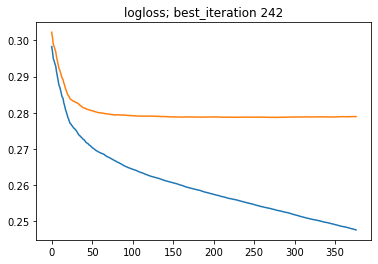

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

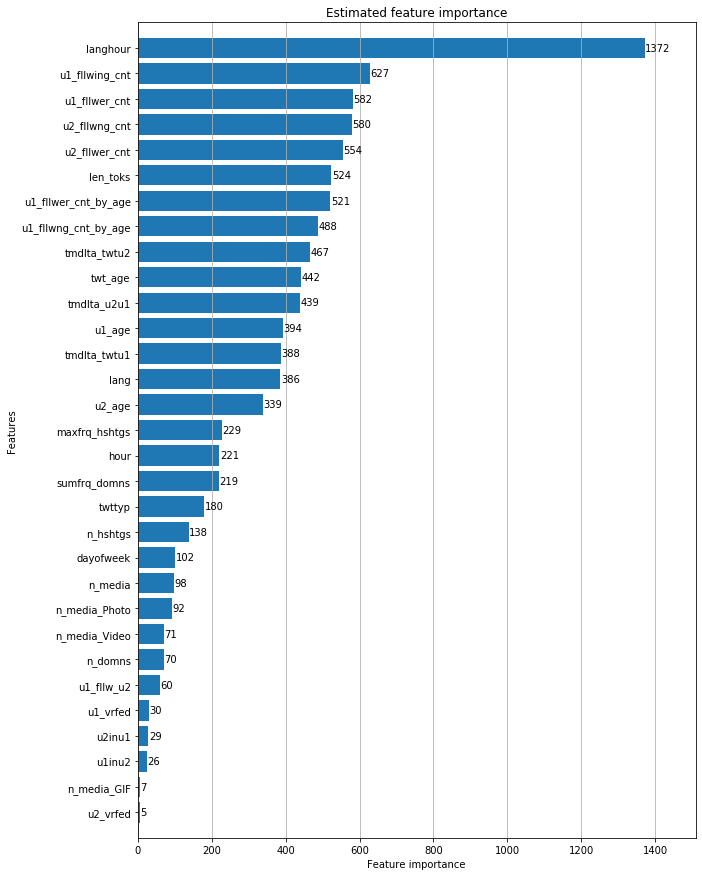

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,1372
3,u1_fllwing_cnt,627
2,u1_fllwer_cnt,582
6,u2_fllwng_cnt,580
5,u2_fllwer_cnt,554
11,len_toks,524
26,u1_fllwer_cnt_by_age,521
27,u1_fllwng_cnt_by_age,488
22,tmdlta_twtu2,467
23,twt_age,442


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 1372),
 ('u1_fllwing_cnt', 627),
 ('u1_fllwer_cnt', 582),
 ('u2_fllwng_cnt', 580),
 ('u2_fllwer_cnt', 554),
 ('len_toks', 524),
 ('u1_fllwer_cnt_by_age', 521),
 ('u1_fllwng_cnt_by_age', 488),
 ('tmdlta_twtu2', 467),
 ('twt_age', 442),
 ('tmdlta_u2u1', 439),
 ('u1_age', 394),
 ('tmdlta_twtu1', 388),
 ('lang', 386),
 ('u2_age', 339),
 ('maxfrq_hshtgs', 229),
 ('hour', 221),
 ('sumfrq_domns', 219),
 ('twttyp', 180),
 ('n_hshtgs', 138),
 ('dayofweek', 102),
 ('n_media', 98),
 ('n_media_Photo', 92),
 ('n_media_Video', 71),
 ('n_domns', 70),
 ('u1_fllw_u2', 60),
 ('u1_vrfed', 30),
 ('u2inu1', 29),
 ('u1inu2', 26),
 ('n_media_GIF', 7),
 ('u2_vrfed', 5)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u1_fllwing_cnt',
 'u1_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_fllwer_cnt',
 'len_toks',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'tmdlta_twtu2',
 'twt_age',
 'tmdlta_u2u1',
 'u1_age',
 'tmdlta_twtu1',
 'lang',
 'u2_age',
 'maxfrq_hshtgs',
 'hour',
 'sumfrq_domns',
 'twttyp',
 'n_hshtgs',
 'dayofweek',
 'n_media',
 'n_media_Photo',
 'n_media_Video',
 'n_domns',
 'u1_fllw_u2',
 'u1_vrfed',
 'u2inu1',
 'u1inu2',
 'n_media_GIF',
 'u2_vrfed']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 50.4 s, sys: 0 ns, total: 50.4 s
Wall time: 15.5 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 6.43 s, sys: 0 ns, total: 6.43 s
Wall time: 12.1 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3194
auc_vl:  0.2117
auc_val: 0.0234

rce_tr:  15.0035
rce_vl:  8.3802
rce_val: 5.3777


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0234-5.3777


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.8 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 21:04:08 start
2020-04-11 21:04:08 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 21:04:08 freq of tags
2020-04-11 21:04:08 done
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 251 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 139 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)